In [66]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pydot
from torchview import draw_graph
import transformers
from transformers import modeling_outputs

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as F


import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pyvis.network import Network

In [2]:
def pretty_print(*objs, indent=0):
    spacing = ' ' * indent
    for obj in objs:
        if isinstance(obj, dict):
            print(f"{spacing}{{")
            for key, value in obj.items():
                print(f"{spacing}  {key}:")
                pretty_print(value, indent + 4)
            print(f"{spacing}}}")
        elif isinstance(obj, (list, tuple)):
            print(f"{spacing}[")
            for item in obj:
                pretty_print(item, indent + 4)
            print(f"{spacing}]")
        elif isinstance(obj, np.ndarray):
            print(f"{spacing}np.array[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, torch.Tensor):
            print(f"{spacing}torch.Tensor[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, torch.nn.Module):
            print(f"{spacing}torch.nn.Module[{obj.dtype}] (shape: {obj.shape})")
        elif isinstance(obj, transformers.tokenization_utils_base.BatchEncoding):
            print(f"{spacing}BatchEncoding (keys: {list(obj.keys())})")
            for key, value in obj.items():
                print(f"{spacing}  {key}:")
                pretty_print(value, indent + 4)
        else:
            print(f"{spacing}{obj}")
            
def visualize_with_pyvis(G, width="1920px", height="1080px", hierarchical=False, file_name="pytorch_model_graph.html"):
    # Create a PyVis network object
    net = Network(notebook=False, directed=True, width=width, height=height)

    # Add nodes and edges from the NetworkX graph
    for node, data in G.nodes(data=True):
        net.add_node(node, title=str(data), label=node)

    for source, target, data in G.edges(data=True):
        net.add_edge(source, target, title=str(data))

    # Apply hierarchical layout
    net.repulsion(
        node_distance=120,
        central_gravity=0.33,
        spring_length=100,
        spring_strength=0.10,
        damping=0.95,
    )

    options = {}
    if hierarchical:
        options["layout"] = {
            "hierarchical": {
                "enabled": True,
                "levelSeparation": 250,
                "nodeSpacing": 400,
                "treeSpacing": 200,
                "blockShifting": False,
                "edgeMinimization": True,
                "parentCentralization": True,
                "direction": "UD",
                "sortMethod": "directed",
            },
            "physics": {
                "enabled": False,
            }
        }
        net.set_options(json.dumps(options))

    # net.show_buttons()

    # Save the network to an HTML file
    net.save_graph(file_name)

In [3]:
class ComplexNetWithBranch(torch.nn.Module):
    def __init__(self):
        super(ComplexNetWithBranch, self).__init__()
        
        # Common layers before branching
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(10, 20),
            torch.nn.ReLU()
        )
        
        self.inner_seq_1 = torch.nn.Sequential(
            torch.nn.Linear(15, 15),
            torch.nn.ReLU()
        )
        self.inner_seq_2 = torch.nn.Sequential(
            torch.nn.Linear(15, 15),
            torch.nn.ReLU()
        )
        
        # Branch 1
        self.branch1 = torch.nn.Sequential(
            torch.nn.Linear(20, 15),
            self.inner_seq_1,
            self.inner_seq_2
        )
        
        # Branch 2
        self.branch2 = torch.nn.Sequential(
            torch.nn.Linear(20, 15),
            torch.nn.ReLU()
        )
        
        # Common layers after recombining
        self.fc_combine = torch.nn.Linear(30, 10)
        self.fc_output = torch.nn.Linear(10, 1)
        
        # ModuleList after recombination
        self.module_list = torch.nn.ModuleList([
            torch.nn.Linear(1, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1)
        ])

    def forward(self, x):
        # Common forward pass before branching
        x = self.seq(x)
        
        # Branching
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        
        # Concatenate the outputs of both branches
        x = torch.cat([branch1_out, branch2_out], dim=1)
        
        # Pass through the combined layer
        x = self.fc_combine(x)
        x = self.fc_output(x)
        
        # ModuleList forward pass
        for layer in self.module_list:
            x = layer(x)
        
        return x


In [4]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.eval()
inceptionv3 = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
gpt2 = transformers.AutoModelForCausalLM.from_pretrained('gpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id
gpt2.eval()
vit = transformers.AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
vit.eval()
complex_net = ComplexNetWithBranch()
complex_net.eval()

imagenette = torchvision.datasets.ImageFolder('/home/insane/U/apalysis-evaluation/dataset-5')
gpt2_custom = [
    'Hello world, sdjfklasdj ksdj fskdj lfskdj fklsadjf lskadjf laskdjf klasdjf klasd jfklasdj fklasd jfklasd jflaksjdf klasdjf aklsdjf klasjd fklasdj fklasfj',
    'I love you',
    'This is my world',
    'Hello, how are you? I am fine, thank you!',
    'Tell me a story on the moon',
]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/insane/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 112MB/s]  
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/insane/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 106MB/s]  


In [5]:
# Display the first image from the imagenette dataset
# image, label = imagenette[0]
# image.show()

In [6]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
sampled_images = torch.utils.data.Subset(imagenette, np.random.choice(len(imagenette), 10, replace=False).tolist())
transformed_images = [transform(image) for image, _ in sampled_images]
input_vgg16 = torch.stack(transformed_images)

transform = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
sampled_images = torch.utils.data.Subset(imagenette, np.random.choice(len(imagenette), 10, replace=False).tolist())
transformed_images = [transform(image) for image, _ in sampled_images]
input_inceptionv3 = torch.stack(transformed_images)

input_complex_net = torch.randn(10, 10)

def gpt2_preprocess(x):
    tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    x = tokenizer(x, return_tensors='pt', padding=True, truncation=True)
    return x

input_gpt2 = gpt2_preprocess(gpt2_custom)
input_vit = np.array([x for x, _ in imagenette])

pretty_print(input_vgg16)
pretty_print(input_inceptionv3)
pretty_print(input_gpt2)
pretty_print(input_vit)

torch.Tensor[torch.float32] (shape: torch.Size([10, 3, 224, 224]))
torch.Tensor[torch.float32] (shape: torch.Size([10, 3, 299, 299]))
BatchEncoding (keys: ['input_ids', 'attention_mask'])
  input_ids:
torch.Tensor[torch.int64] (shape: torch.Size([5, 79]))
4
  attention_mask:
torch.Tensor[torch.int64] (shape: torch.Size([5, 79]))
4
np.array[uint8] (shape: (25, 299, 299, 3))


In [7]:
with torch.no_grad():
    pretty_print("vgg16", vgg16(input_vgg16))
    pretty_print("inceptionv3", inceptionv3(input_inceptionv3))
    # pretty_print("gpt2", gpt2(input_gpt2))
    # pretty_print("vit", vit(input_vit))
    pretty_print("complex_net", complex_net(input_complex_net))

vgg16
torch.Tensor[torch.float32] (shape: torch.Size([10, 1000]))
inceptionv3
[
torch.Tensor[torch.float32] (shape: torch.Size([10, 1000]))
4
torch.Tensor[torch.float32] (shape: torch.Size([10, 1000]))
4
]
complex_net
torch.Tensor[torch.float32] (shape: torch.Size([10, 1]))


In [8]:
vgg16_layers = list(
    map(
        lambda l: l[0],
        vgg16.named_modules()
    )
)

inceptionv3_layers = list(
    map(
        lambda l: l[0],
        inceptionv3.named_modules()
    )
)

gpt2_layers = list(
    map(
        lambda l: l[0],
        gpt2.transformer.named_modules()
    )
)

vit_layers = list(
    map(
        lambda l: l[0],
        vit.named_modules()
    )
)

complex_net_layers = list(
    map(
        lambda l: l[0],
        complex_net.named_modules()
    )
)   

print(vgg16_layers)
print(inceptionv3_layers)
print(gpt2_layers)
print(vit_layers)
print(complex_net_layers)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']
['', 'Conv2d_1a_3x3', 'Conv2d_1a_3x3.conv', 'Conv2d_1a_3x3.bn', 'Conv2d_2a_3x3', 'Conv2d_2a_3x3.conv', 'Conv2d_2a_3x3.bn', 'Conv2d_2b_3x3', 'Conv2d_2b_3x3.conv', 'Conv2d_2b_3x3.bn', 'maxpool1', 'Conv2d_3b_1x1', 'Conv2d_3b_1x1.conv', 'Conv2d_3b_1x1.bn', 'Conv2d_4a_3x3', 'Conv2d_4a_3x3.conv', 'Conv2d_4a_3x3.bn', 'maxpool2', 'Mixed_5b', 'Mixed_5b.branch1x1', 'Mixed_5b.branch1x1.conv', 'Mixed

In [9]:
# Function to create unique layer names
def get_layer_name(module_name: str, parent_name: str | None = None) -> str:
    if parent_name:
        return f"{parent_name}_{module_name}"
    return module_name

# Hook function to add nodes and edges to the graph
def add_to_graph(
        G: nx.MultiDiGraph,
        module: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict,
        layer_name: str,
        output: torch.Tensor | tuple[torch.Tensor, ...] | dict[str, torch.Tensor],
        parent_name: str | None,
        previous_layer_names: list[str]
    ) -> None:
    print(f"Adding layer {layer_name} to the graph")
    # Get the layer type, dtype, and shape
    layer_type = module.__class__.__name__
    if isinstance(output, tuple):
        output = output[0]
    elif isinstance(output, dict):
        if 'last_hidden_state' in output:
            output = output['last_hidden_state']
        elif 'logits' in output:
            output = output['logits']
        else:
            raise ValueError(f"Unknown output type: {output}")
    output_type = str(output.dtype)
    output_shape = tuple(output.shape)

    # Add node with attributes
    G.add_node(
        layer_name,
        output=output,
        output_type=output_type,
        output_shape=output_shape,
        layer_type=layer_type,
    )

    # Add edge from the previous layer to the current layer if it's not the input layer
    if previous_layer_names:
        for previous_layer_name in previous_layer_names:
            print(f"Adding edge from {previous_layer_name} to {layer_name} (data_flow)")
            G.add_edge(previous_layer_name, layer_name, edge_type="data_flow")

    if parent_name:
        print(f"Adding edge from {parent_name} to {layer_name} (parent)")
        G.add_edge(parent_name, layer_name, edge_type="parent")

def extract_activations_graph(model: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict, input_tensor: torch.Tensor | dict | transformers.tokenization_utils_base.BatchEncoding) -> nx.DiGraph:
    G = nx.MultiDiGraph()
    
   # Stack to keep track of previous layers including branches
    prev_layers_stack: list[list[str]] = []

    # Function to recursively register hooks on all layers
    def register_hooks(module: torch.nn.Module | torch.nn.ModuleList | torch.nn.Sequential | torch.nn.ModuleDict, module_name: str, parent_name: str | None) -> None:
        def forward_hook(module, input, output):
            previous_layer_names = prev_layers_stack.pop() if prev_layers_stack else []
            add_to_graph(G, module, module_name, output, parent_name, previous_layer_names)
            prev_layers_stack.append([module_name])

        handle = module.register_forward_hook(forward_hook)

        for name, child_module in module.named_children():
            current_child_name = get_layer_name(name, module_name)
            prev_layers_stack.append([module_name])
            register_hooks(child_module, current_child_name, module_name)

    # Register hooks starting from the root model
    register_hooks(model, type(model).__name__, None)

    try:
        # Perform a forward pass with the input tensor to populate the graph
        with torch.no_grad():
            if isinstance(input_tensor, (dict, transformers.tokenization_utils_base.BatchEncoding)):
                model(**input_tensor)
            else:
                model(input_tensor)
    finally:
        # remove all hooks
        for module in model.modules():
            module._forward_hooks.clear()
            module._forward_pre_hooks.clear()
    
    G_hierarchy = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_hierarchy.edges(data=True) if d.get("edge_type") == "data_flow"]
    G_hierarchy.remove_edges_from(edges_to_remove)

    G_dataflow = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_dataflow.edges(data=True) if d.get("edge_type") == "parent"]
    G_dataflow.remove_edges_from(edges_to_remove)
    
    for node in G_hierarchy.nodes():
        if G_hierarchy.out_degree(node) != 0:
            child_nodes = [child for child in G_hierarchy.successors(node)]
            for child in child_nodes:
                if G_dataflow.out_degree(child) == 0:
                    G.add_edge(child, node, edge_type="data_flow")
                else:
                    next_child_nodes = [v for u, v, d in G_dataflow.edges(child, data=True)]
                    if all(G_hierarchy.has_edge(child, next_child) for next_child in next_child_nodes):
                        G.add_edge(child, node, edge_type="data_flow")
                        

    return G




# model_graph = extract_activations_graph(vgg16, input_vgg16)
# model_graph = extract_activations_graph(inceptionv3, input_inceptionv3)
model_graph = extract_activations_graph(complex_net, input_complex_net)
visualize_with_pyvis(model_graph, file_name="whole_model.html")

model_graph_hierarchy = nx.DiGraph((u, v, d) for u, v, d in model_graph.edges(data=True) if d.get('edge_type') == 'parent')
assert nx.is_directed_acyclic_graph(model_graph_hierarchy), "The graph must be acyclic!"
nodes_not_in_hierarchy = set(model_graph.nodes()) - set(model_graph_hierarchy.nodes())
print("Nodes not in model_graph_hierarchy:", nodes_not_in_hierarchy)
model_graph_hierarchy.add_nodes_from([(node, data) for node, data in model_graph.nodes(data=True) if node in nodes_not_in_hierarchy])
visualize_with_pyvis(model_graph_hierarchy, file_name="whole_model_hierarchy.html", hierarchical=True)

model_graph_dataflow = nx.DiGraph((u, v, d) for u, v, d in model_graph.edges(data=True) if d['edge_type'] == 'data_flow')
nodes_not_in_dataflow = set(model_graph.nodes()) - set(model_graph_dataflow.nodes())
print("Nodes not in model_graph_dataflow:", nodes_not_in_dataflow)
model_graph_dataflow.add_nodes_from([(node, data) for node, data in model_graph.nodes(data=True) if node in nodes_not_in_dataflow])
visualize_with_pyvis(model_graph_dataflow, file_name="whole_model_data_flow.html", hierarchical=False)

Adding layer ComplexNetWithBranch_seq_0 to the graph
Adding edge from ComplexNetWithBranch_module_list to ComplexNetWithBranch_seq_0 (data_flow)
Adding edge from ComplexNetWithBranch_seq to ComplexNetWithBranch_seq_0 (parent)
Adding layer ComplexNetWithBranch_seq_1 to the graph
Adding edge from ComplexNetWithBranch_seq_0 to ComplexNetWithBranch_seq_1 (data_flow)
Adding edge from ComplexNetWithBranch_seq to ComplexNetWithBranch_seq_1 (parent)
Adding layer ComplexNetWithBranch_seq to the graph
Adding edge from ComplexNetWithBranch_seq_1 to ComplexNetWithBranch_seq (data_flow)
Adding edge from ComplexNetWithBranch to ComplexNetWithBranch_seq (parent)
Adding layer ComplexNetWithBranch_branch1_0 to the graph
Adding edge from ComplexNetWithBranch_seq to ComplexNetWithBranch_branch1_0 (data_flow)
Adding edge from ComplexNetWithBranch_branch1 to ComplexNetWithBranch_branch1_0 (parent)
Adding layer ComplexNetWithBranch_inner_seq_1_0 to the graph
Adding edge from ComplexNetWithBranch_branch1_0 t

In [10]:
def add_module_to_graph(module, parent_name, graph):
    """
    Recursively add PyTorch module to a networkx graph, including hierarchical structure.
    
    Parameters:
    - module: PyTorch module to process.
    - parent_name: Name of the parent module (used to create hierarchical node names).
    - graph: NetworkX graph to add nodes and edges to.
    """
    for name, child in module.named_children():
        child_name = f"{parent_name}->{name}"
        graph.add_node(child_name, layer=type(child).__name__)  # Add child node

        # Add a 'parent' edge for the hierarchy
        graph.add_edge(parent_name, child_name, edge_type='parent')

        # If the child is a Sequential or ModuleList, handle sublayers
        if isinstance(child, (nn.Sequential, nn.ModuleList)):
            for i, subchild in enumerate(child):
                subchild_name = f"{child_name}->{i}"
                graph.add_node(subchild_name, layer=type(subchild).__name__)  # Add sublayer node

                # Add edges from the Sequential/ModuleList to sublayers
                graph.add_edge(child_name, subchild_name, edge_type='parent')

                # Recurse into sublayer if needed
                add_module_to_graph(subchild, subchild_name, graph)
        else:
            # Recurse for standard layers
            add_module_to_graph(child, child_name, graph)

def hook_factory(name, graph, data_flow_edges, previous_layer_tracker):
    """
    Create a hook function that logs the data flow from one layer to the next.
    
    Parameters:
    - name: The name of the current layer.
    - graph: The NetworkX graph being built.
    - data_flow_edges: A list to log the data flow edges.
    - previous_layer_tracker: A dictionary to globally track the previous layer across hooks.
    """
    def hook(module, input, output):
        previous_layer = previous_layer_tracker["prev"]

        # If there's a previous layer, add a data flow edge between previous and current layer
        if previous_layer is not None:
            data_flow_edges.append((previous_layer, name))
        
        # Update previous_layer to the current one
        previous_layer_tracker["prev"] = name
        
        return output
    return hook

def create_model_graph(model, input_tensor):
    """
    Create a networkx graph from a PyTorch model, capturing both structure and data flow.
    
    Parameters:
    - model: The PyTorch model instance to be processed.
    - input_tensor: A tensor that can be passed through the model to trace the forward pass.
    
    Returns:
    - graph: A NetworkX directed graph representing the model.
    """
    graph = nx.DiGraph()  # Use a directed graph for layer flow
    data_flow_edges = []  # To track the flow of data (tensor passing)
    previous_layer_tracker = {"prev": None}  # To track the previous layer globally

    # Start from the root node
    root_name = type(model).__name__
    graph.add_node(root_name, layer=type(model).__name__)
    
    # Recursively add modules to the graph
    add_module_to_graph(model, root_name, graph)
    
    # Register hooks on each layer to track the data flow
    handles = []
    for name, module in model.named_modules():
        # Ignore the root module itself
        if name != '':
            # Use full name for the layer in the graph (matches hierarchy)
            full_layer_name = f"{root_name}->{name}"
            handle = module.register_forward_hook(hook_factory(full_layer_name, graph, data_flow_edges, previous_layer_tracker))
            handles.append(handle)
    
    # Run a forward pass to log data flow
    model(input_tensor)
    
    # Add the data flow edges to the graph
    for (src, dst) in data_flow_edges:
        if src in graph.nodes and dst in graph.nodes:
            graph.add_edge(src, dst, edge_type='data_flow')
    
    # Remove hooks after tracing
    for handle in handles:
        handle.remove()

    return graph

model = ComplexNetWithBranch()

# Create a dummy input tensor matching the input size of the model (e.g., 10 features)
input_tensor = torch.randn(1, 10)

# Create the model graph
model_graph = create_model_graph(model, input_tensor)

visualize_with_pyvis(model_graph, file_name="whole_model_graph.html", hierarchical=False)

model_graph_dataflow = nx.DiGraph((u, v, d) for u, v, d in model_graph.edges(data=True) if d['edge_type'] == 'data_flow')
nodes_to_remove = [node for node in model_graph_dataflow.nodes if node.isdigit() and len(node) > 5]

for node in nodes_to_remove:
    predecessors = list(model_graph_dataflow.predecessors(node))
    successors = list(model_graph_dataflow.successors(node))
    
    for pred in predecessors:
        for succ in successors:
            model_graph_dataflow.add_edge(pred, succ, edge_type='data_flow')
    
    model_graph_dataflow.remove_node(node)

visualize_with_pyvis(model_graph_dataflow, file_name="whole_model_data_flow.html", hierarchical=False)

In [91]:
computation_graph = draw_graph(
    ComplexNetWithBranch(),
    input_size=(1, 10),
    expand_nested=True,
    depth=5,
    hide_module_functions=False,
    hide_inner_tensors=False,
    roll=True,
    show_shapes=True,
)
graphviz_graph = computation_graph.visual_graph

In [92]:
pydot_graph = pydot.graph_from_dot_data(graphviz_graph.source)[0]
nx_graph = nx.nx_pydot.from_pydot(pydot_graph)

# Print all nodes and their attributes in a readable format
print("Nodes and their attributes:")
print("-" * 50)
for node, attrs in nx_graph.nodes(data=True):
    print(f"\nNode: {node}")
    if attrs:
        print("Attributes:")
        for key, value in attrs.items():
            print(f"  {key}: {value}")
    else:
        print("  No attributes")
print("-" * 50)


visualize_with_pyvis(nx_graph, file_name="test.html", hierarchical=False)

Nodes and their attributes:
--------------------------------------------------

Node: 0
Attributes:
  label: <
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                        <TR><TD>input-tensor<BR/>depth:0</TD><TD>(1, 10)</TD></TR>
                    </TABLE>>
  fillcolor: lightyellow

Node: 19
Attributes:
  label: <
                    <TABLE BORDER="0" CELLBORDER="1"
                    CELLSPACING="0" CELLPADDING="4">
                    <TR>
                        <TD ROWSPAN="2">cat<BR/>depth:1</TD>
                        <TD COLSPAN="2">input:</TD>
                        <TD COLSPAN="2">2 x (1, 15) </TD>
                    </TR>
                    <TR>
                        <TD COLSPAN="2">output: </TD>
                        <TD COLSPAN="2">(1, 30) </TD>
                    </TR>
                    </TABLE>>
  fillcolor: aliceblue

Node: 20
Attributes:
  label: <
                    <TABLE BORDER="0" C

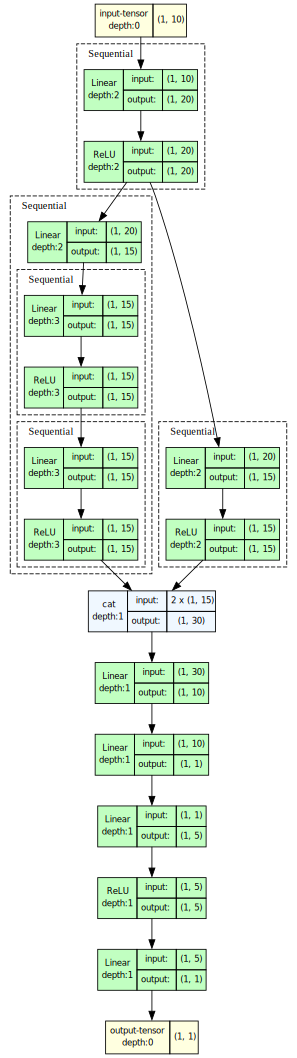

In [38]:
model_graph = draw_graph(ComplexNetWithBranch(), input_size=(1, 10), expand_nested=True)
model_graph.visual_graph


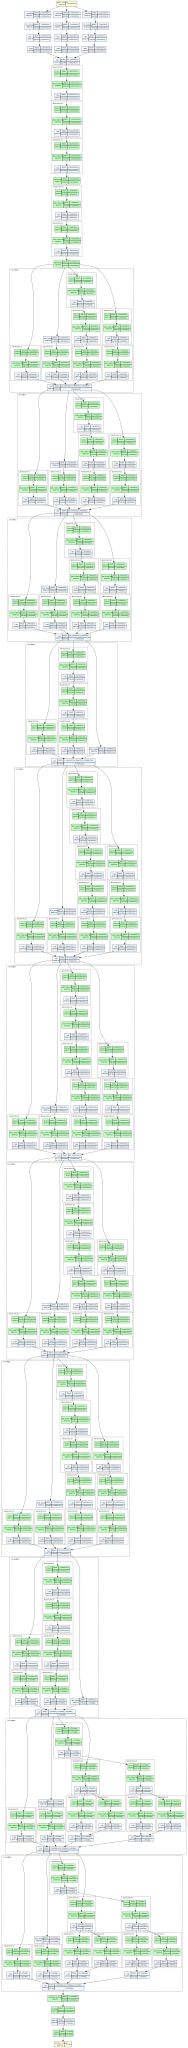

In [ ]:
model_graph = draw_graph(inceptionv3, input_size=(1, 3, 224, 224), expand_nested=True)
model_graph.visual_graph

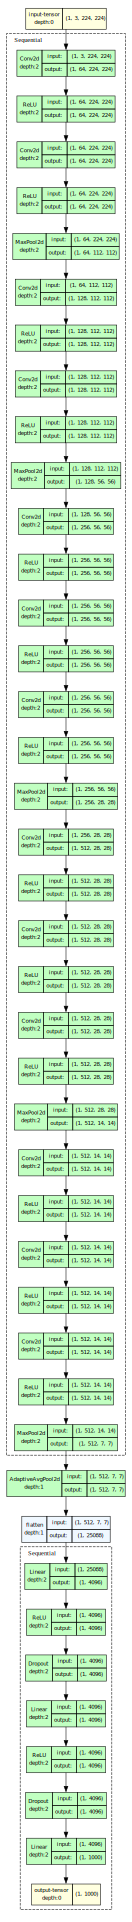

In [ ]:
model_graph = draw_graph(vgg16, input_size=(1, 3, 224, 224), expand_nested=True)
model_graph.visual_graph

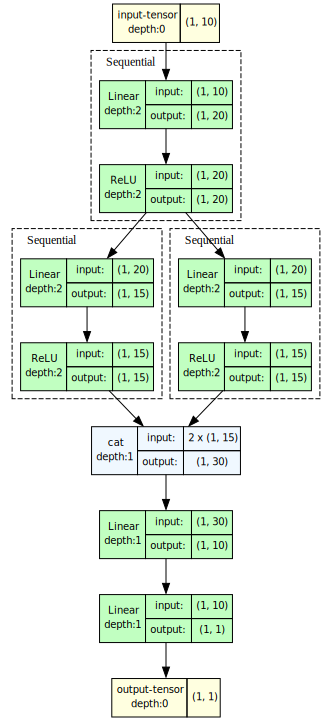

In [33]:

model_graph = draw_graph(model, input_size=(1, 10), expand_nested=True)
model_graph.visual_graph